# Lab Assignment Two: Exploring Image Data

Tela Sorrell, Kiswood Diogene, Martin Menard, and Emily Davidson

### Business Understanding

The data set that we selected features 75 different classes of butterflies, and it contains about 1000+ labelled images including validation images with each image belonging to only one butterfly class. The purpose of this data set is to predict what butterfly class the butterfly in the image belongs to, and the data was collected to strengthen butterfly classification in images. The data set has a butterfly category, which lists 75 categories of butterflies, and it will be used as the prediction task.

In our opinion, the third parties that would be interested in these results are lepidopterists societies or lepidopterists, who are entomologists who specialize in the study or collection of butterflies and moths, because this data will play a vital role in simplifying the identification and classification of butterflies in images for them. Lepidopterists examine the behavior and evolutionary history of various moth and butterfly species and document their activities, questions, ideas, problems, progress, and everything they have learned about butterfly specicies, so having this data can save time and minimize research necessary to classify butterfly species. They can utilize our prediction models to cross reference with the images they have taken themselves to get a strong conclusion about the class of butterfly they have captured.

According to research, our prediction algorithm would need to perform at about 88% accuracy to be considered useful to the identified third parties because current models that have been created to classify butterflies are performing at the lowest 84% and at the highest about 90%.

</br>

[Lepidoptery Source](https://www.ascd.org/el/articles/what-do-lepidopterists-do)
</br>
[Classification of Butterfly Species Using Pretrained Models Source](https://www.mdpi.com/2079-9292/11/13/2016)


### Data Preparation

[.5 points] Read in your images as numpy arrays. Resize and recolor images as necessary.
[.4 points] Linearize the images to create a table of 1-D image features (each row should be one image).   
[.1 points] Visualize several images.

In [222]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

##### Imports

In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn import preprocessing
import plotly.express as px
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE


##### Load in the Butterfly DataSet

In [ ]:
def image_shrink(image, size=(100,100)):
    return cv2.resize(image, size)

In [ ]:
# Read in images as numpy arrays
def load_images_from_folder(folder, size=(100,100)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = image_shrink(img, size)
        if img is not None:
            print(f"Loaded image shape: {img.shape}")
            images.append(img)
    return images

In [ ]:
images = load_images_from_folder('Images')
print(f"Loaded {len(images)} images")

Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image s

In [ ]:
labels_df = pd.read_csv('Training_set.csv')
labels_df.head()

filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART

In [ ]:
filename_to_species = dict(zip(labels_df['filename'], labels_df['label']))

In [ ]:
class_labels = [filename_to_species[os.path.basename(filename)] for filename in os.listdir('Images')]
print(class_labels)

['DANAID EGGFLY', 'MOURNING CLOAK', 'MOURNING CLOAK', 'WOOD SATYR', 'GREY HAIRSTREAK', 'STRAITED QUEEN', 'GREAT JAY', 'INDRA SWALLOW', 'AFRICAN GIANT SWALLOWTAIL', 'RED SPOTTED PURPLE', 'RED POSTMAN', 'EASTERN PINE ELFIN', 'CHESTNUT', 'IPHICLUS SISTER', 'AFRICAN GIANT SWALLOWTAIL', 'ULYSES', 'ELBOWED PIERROT', 'RED CRACKER', 'SOOTYWING', 'EASTERN COMA', 'STRAITED QUEEN', 'SLEEPY ORANGE', 'PIPEVINE SWALLOW', 'GOLD BANDED', 'SILVER SPOT SKIPPER', 'RED SPOTTED PURPLE', 'MESTRA', 'CLEOPATRA', 'PEACOCK', 'EASTERN COMA', 'STRAITED QUEEN', 'SCARCE SWALLOW', 'MALACHITE', 'PURPLE HAIRSTREAK', 'ORCHARD SWALLOW', 'CRIMSON PATCH', 'VICEROY', 'MESTRA', 'BLACK HAIRSTREAK', 'DANAID EGGFLY', 'RED POSTMAN', 'SLEEPY ORANGE', 'SCARCE SWALLOW', 'ORANGE TIP', 'BANDED ORANGE HELICONIAN', 'ELBOWED PIERROT', 'MALACHITE', 'EASTERN PINE ELFIN', 'MANGROVE SKIPPER', 'PIPEVINE SWALLOW', 'MILBERTS TORTOISESHELL', 'SLEEPY ORANGE', 'CABBAGE WHITE', 'CLOUDED SULPHUR', 'CHECQUERED SKIPPER', 'MOURNING CLOAK', 'ELBOWED P

In [ ]:
# Linearize images to create table of 1-D image features (Turn into 1 row)
# Refrenced: https://stackoverflow.com/questions/36967920/numpy-flatten-rgb-image-array
def linearize_img(images):
    flattened = np.array([img.flatten() for img in images])
    print(flattened.shape)
    print(f"Flattened images shape: {flattened.shape}")
    return flattened

In [ ]:
flat_images = linearize_img(images)
print(f"Flattened into single array of shape {flat_images.shape}")
print(flat_images)

(6499, 30000)
Flattened images shape: (6499, 30000)
Flattened into single array of shape (6499, 30000)
[[ 43  48  25 ... 139 167 191]
 [234 239 246 ... 166 126 130]
 [181 177 158 ... 139 120  86]
 ...
 [ 16  43   2 ... 138 165  75]
 [147 149 125 ... 127 109  63]
 [ 49  61  39 ...  97 131  61]]


In [ ]:
def list_images(images,titles, num_row = 5,num_col=5):
    plt.figure(figsize=(3 * num_col, num_row *3))
    for i in range (num_row*num_col):
        if i < len(images):
            plt.subplot(num_row, num_col, i + 1)
            plt.imshow(images[i])
            plt.imshow(images[i])
            plt.title (titles[i], fontsize = 8)
            plt.axis('off')
    plt.tight_layout
    plt.show()

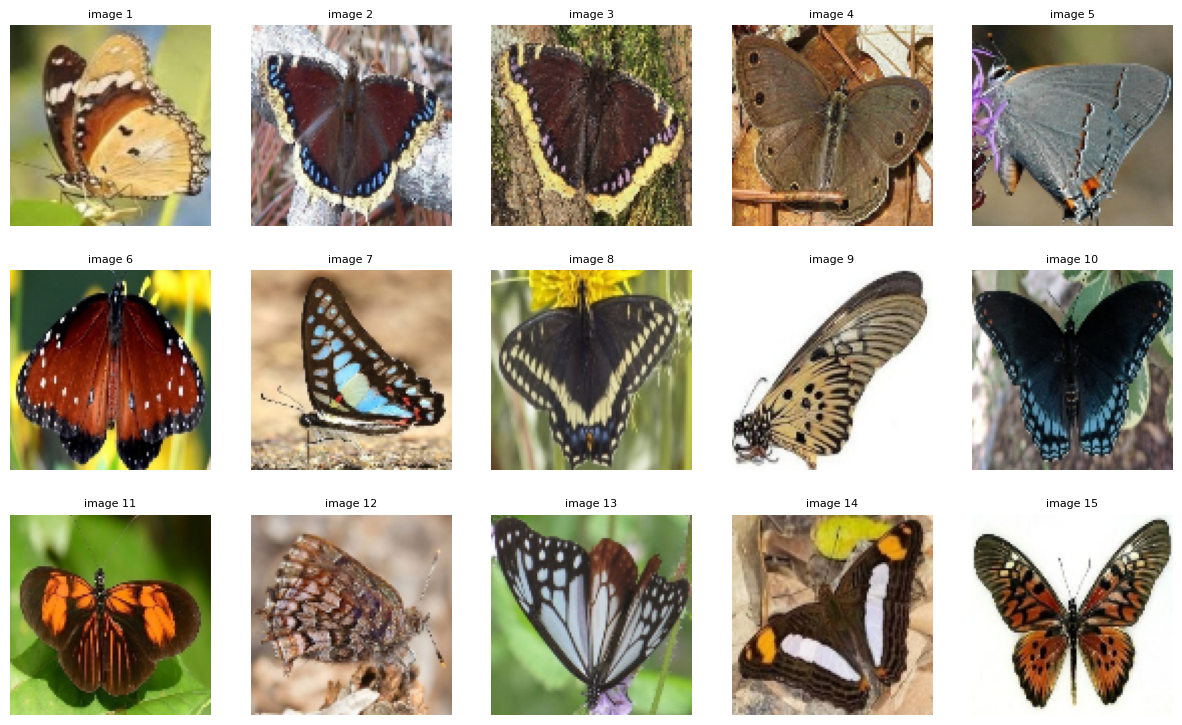

In [ ]:
titles = [f'image {i+1}'for i in range(len(images))]
list_images(images[:25],titles[:25], num_row=3, num_col=5)

### Data Reduction

In [230]:
# Applying a Standard Scaler
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# Referenced https://stackoverflow.com/questions/37221425/which-feature-scaling-method-to-use-before-pca
# Scales the data so every column (feature) can have a mean of 0 and a St.dev of 1

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(flat_images)


In [233]:
num_of_components = 10
pca = PCA(n_components=num_of_components)
components = pca.fit_transform(flat_images)
print('pca:', components)

pca: [[ 4117.40004198  3319.12837227 -1954.24851262 ...   239.33509543
   -825.98129185    70.56211008]
 [ 4940.04976441 -3576.22407846  1143.9061625  ... -1021.6745071
  -2178.87703539 -1364.51367602]
 [-1621.03957178 -3064.9343602    111.64930909 ...  -388.11400055
  -1453.42721189  -213.90554487]
 ...
 [-2996.07187436  -504.88913562  -642.88359887 ...   952.44014847
   -315.55444304 -1134.08949193]
 [  178.7273492   -396.23241522  -918.29333761 ...  -861.56001997
   1347.81420488  1367.78721559]
 [ -614.13124662  8059.18325637  2621.14979692 ...  -111.89135743
    530.46972761  1447.84079879]]


In [241]:
titles = [f'image {i+1}' for i in range(len(images))]
df_pca = pd.DataFrame(components, columns=[f'PC{i+1}' for i in range(num_of_components)])
df_pca['title'] = titles
df_pca['class'] = class_labels

fig = px.scatter(df_pca, x='PC1', y='PC2', color='class', hover_name='title', title='PCA of Butterfly Data')
fig.show()

**Shows data points are spreaded but classes are not seperated which means that we may need more components. We will check how much variance each component has and if it doesn't capture much variance we will likely need to add more**

In [243]:
# Reference https://stats.stackexchange.com/questions/584174/interpretation-of-low-variance-in-pca
# Reference https://stackoverflow.com/questions/32857029/python-scikit-learn-pca-explained-variance-ratio-cutoff
# Reference https://stackoverflow.com/questions/74296474/how-to-interpret-explained-variance-ratio-plot-from-principal-components-of-pca
# Refence   https://stackoverflow.com/questions/57293716/sklearn-pca-explained-variance-and-explained-variance-ratio-difference

explain_var_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explain_var_ratio)

fig = px.bar(
    x=[f'PC {i+1}' for i in range(len(explain_var_ratio))],
    y=explain_var_ratio,
    labels={'x': 'Principal Component', 'y': 'Explained Variance Ratio'},
    title='Explained Variance Ratio of Principal Components'
)
fig.show()

**We use this to understand the explained variance to understand how much variance each component has to determine how many components to consider**

In [244]:
fig = px.scatter(df_pca, x='PC1', y='PC2', color='class', hover_name='title', title='PCA of Butterfly Data')
fig.show()

#### Reference: https://medium.com/@abhishek8694/linear-vs-non-linear-dimensionality-reduction-pca-and-kernel-pca-10490f345ba9#:~:text=However%2C%20PCA%20has%20limitations%20when,underlying%20structure%20of%20the%20data.
**We standardized the data using standard scaler to help the PCA. We showing 10 principal components which didn't really improve class seperation (Which could be due to our complex data set of butterfly images which are high dimensional and have non-linear patterns that PCA may not capture well)**

In [252]:
# Reference: https://ml-lectures.org/docs/structuring_data/ml_without_neural_network-3.html
# Reference: https://www.datacamp.com/tutorial/introduction-t-sne
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, learning_rate=200)
tsne_components = tsne.fit_transform(flat_images)

df_tsne = pd.DataFrame(tsne_components, columns=['TSNE1', 'TSNE2'])
df_tsne['title'] = [f'image {i+1}' for i in range(len(images))]
df_tsne['class'] = class_labels

We used T-SNE, an unsupervised non-linear dimensionality reduction technique for data exploration and visualizing high-dimensional data. Non-linear dimensionality reduction means that the algorithm allows us to separate data that cannot be separated by a straight line. T-SNE allows for a non-linear dimensionality reduction technique to capture complex patterns in the data.

Each butterfly has many different feautures using T-SNE we can understand how these butterflies group together based on these features

t-SNE helps reduce complexity by taking all features and compresses them into just 2 or 3 values while trying to keep butterflies that are similar close to each other.


In [254]:
fig = px.scatter(df_tsne, x='TSNE1', y='TSNE2', color='class', hover_name='title', title='t-SNE of Butterfly Data')
fig.show()

#### Exceptional Work

We believe that our report is coherent, useful, and polished. Overall, our goal was to look deeper into heart failure patients and see if there were any correlations between DEATH_EVENT and the 12 other clinical features. Our report makes sense overall, and our visualizations aim to answer the questions we asked toward the beginning of the report. In conclusion, we sought to figure out if diabetes, HBP, smoking, and other features caused death in heart failure patients, and we can conclude that there are not many features that directly cause a heart failure patient to die. However, medical professionals should be prepared to create thorough medical plans for males with heart failure because they die at a much greater rate than women reagrdless of age. Additonally, serum creatinine levels should be monitored in all heart failure patients because increases in those levels beyond the normal range are linked to death in majority of heart failure patients regardless of age and sex. We have properly cited sources to the best of our knowledge, and we provide specificity, logic, and reason with all of our assessments. At this time, subsequent questions could be asked as many curiosities arise, but our main question was the following: </br>
Will a heart failure patient survive or not?

We believe our analysis gives insight to this question.


##### Additional Analysis

One idea (required for 7000 level students): Perform feature extraction upon the images using DAISY. Rather than using matching on the images with the total DAISY vector, you will instead use key point matching. You will need to investigate appropriate methods for key point matching using DAISY. NOTE: this often requires some type of brute force matching per pair of images, which can be computationally expensive. Does it perform better than not using key point matching?